Classifier Training and Evaluation

Train 5 different classifiers on YAMNet embeddings:
1. Logistic Regression (baseline)
2. Random Forest
3. Gradient Boosting (XGBoost)
4. Support Vector Machine (SVM)
5. Multi-Layer Perceptron (MLP)

Each classifier is evaluated on validation set and saved for later comparison.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_score,
                             recall_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

TRAIN_FEATURES_DIR = '../data/approach1/features/train'
VAL_FEATURES_DIR = '../data/approach1/features/val'
TEST_FEATURES_DIR = '../data/approach1/features/test'
MODELS_DIR = '../models/models_approach1'
RESULTS_DIR = '../results/results_approach1'
RANDOM_SEED = 42
N_FOLDS = 3

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
np.random.seed(RANDOM_SEED)

In [2]:
print("LOADING PRE-SPLIT DATA")

# Load training set
X_train = np.load(os.path.join(TRAIN_FEATURES_DIR, 'yamnet_features.npy'))
y_train = np.load(os.path.join(TRAIN_FEATURES_DIR, 'yamnet_labels.npy'))
train_metadata = pd.read_csv(os.path.join(TRAIN_FEATURES_DIR, 'yamnet_features_metadata.csv'))

# Load validation set
X_val = np.load(os.path.join(VAL_FEATURES_DIR, 'yamnet_features.npy'))
y_val = np.load(os.path.join(VAL_FEATURES_DIR, 'yamnet_labels.npy'))
val_metadata = pd.read_csv(os.path.join(VAL_FEATURES_DIR, 'yamnet_features_metadata.csv'))

print(f"\nTraining set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Feature dim: {X_train.shape[1]}")

LOADING PRE-SPLIT DATA

Training set: 5,932 samples
Validation set: 824 samples
Feature dim: 1024


In [3]:
# ==================== ENCODE LABELS ====================
# Fit label encoder on training data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

classes = label_encoder.classes_
print(f"\nClasses ({len(classes)}): {', '.join(classes)}")

# Display class distribution
print(f"\n{'Split':<12} {'Category':<20} {'Count':<10} {'Percentage':<10}")
print("-"*60)
for split_name, y_split in [('Train', y_train_encoded), ('Val', y_val_encoded)]:
    for idx, cls in enumerate(classes):
        count = np.sum(y_split == idx)
        percentage = count / len(y_split) * 100
        print(f"{split_name:<12} {cls:<20} {count:<10} {percentage:>6.2f}%")
    print("-"*60)


Classes (6): Alarm_Clock, Background, Car_Horn, Glass_Breaking, Gunshot, Siren

Split        Category             Count      Percentage
------------------------------------------------------------
Train        Alarm_Clock          918         15.48%
Train        Background           974         16.42%
Train        Car_Horn             1028        17.33%
Train        Glass_Breaking       844         14.23%
Train        Gunshot              1064        17.94%
Train        Siren                1104        18.61%
------------------------------------------------------------
Val          Alarm_Clock          132         16.02%
Val          Background           142         17.23%
Val          Car_Horn             144         17.48%
Val          Glass_Breaking       92          11.17%
Val          Gunshot              158         19.17%
Val          Siren                156         18.93%
------------------------------------------------------------


In [4]:
# ==================== SCALE FEATURES ====================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Save scaler and encoder
joblib.dump(scaler, os.path.join(MODELS_DIR, 'feature_scaler.pkl'))
joblib.dump(label_encoder, os.path.join(MODELS_DIR, 'label_encoder.pkl'))
print(f"\nSaved scaler and label encoder to: {MODELS_DIR}")


Saved scaler and label encoder to: ../models/models_approach1


In [16]:
# DEFINE CLASSIFIERS AND HYPERPARAMETERS
classifiers = {
    'Logistic_Regression': {
        'model': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, n_jobs=-1),
        'params': {
            'C': [1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        },
        'scaled': True
    },
    'Random_Forest': {
        'model': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
        'params': {
            'n_estimators': [100],
            'max_depth': [10],
            'min_samples_split': [5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt']
        },
        'scaled': False
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(
            random_state=RANDOM_SEED,
            n_jobs=-1,
            objective='multi:softprob',
            eval_metric='mlogloss',
            tree_method='hist',
            num_class=len(classes)
        ),
        'params': {
            'n_estimators': [100],
            'max_depth': [3, 5],
            'learning_rate': [0.1],
            'subsample': [0.8],
            'colsample_bytree': [0.8]
        },
        'scaled': False
    },
    'SVM': {
        'model': SVC(random_state=RANDOM_SEED, probability=True, cache_size=2000),
        'params': {
            'C': [1, 10],
            'kernel': ['rbf'],
            'gamma': ['scale']
        },
        'scaled': True
    }
}

print("\nClassifiers to train:")
for idx, name in enumerate(classifiers.keys(), 1):
    config = classifiers[name]
    n_combinations = np.prod([len(v) for v in config['params'].values()])
    print(f"{idx}. {name:<25} {n_combinations:>3} hyperparameter combinations")




Classifiers to train:
1. Logistic_Regression         2 hyperparameter combinations
2. Random_Forest               2 hyperparameter combinations
3. XGBoost                     2 hyperparameter combinations
4. SVM                         2 hyperparameter combinations


In [33]:
print("TRAINING CLASSIFIERS")

results = {}
best_models = {}

for name, config in classifiers.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")

    # Use scaled or unscaled features based on model requirements
    X_tr = X_train_scaled if config['scaled'] else X_train
    X_va = X_val_scaled if config['scaled'] else X_val

    # Grid search with cross-validation on training set
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED),
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_tr, y_train_encoded)

    # Get best model
    model = grid.best_estimator_
    best_models[name] = model

    # Validation predictions
    y_val_pred = model.predict(X_va)
    y_val_proba = model.predict_proba(X_va)

    # Calculate validation metrics
    val_metrics = {
        'accuracy': accuracy_score(y_val_encoded, y_val_pred),
        'precision': precision_score(y_val_encoded, y_val_pred, average='macro'),
        'recall': recall_score(y_val_encoded, y_val_pred, average='macro'),
        'f1_macro': f1_score(y_val_encoded, y_val_pred, average='macro'),
        'f1_weighted': f1_score(y_val_encoded, y_val_pred, average='weighted')
    }

    results[name] = {
        'best_params': grid.best_params_,
        'cv_f1': grid.best_score_,
        'val_metrics': val_metrics,
        'val_pred': y_val_pred,
        'val_proba': y_val_proba
    }

    print(f"\nBest Parameters: {grid.best_params_}")
    print(f"CV F1 (macro): {grid.best_score_:.4f}")
    print(f"Validation Metrics:")
    print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"  Precision: {val_metrics['precision']:.4f}")
    print(f"  Recall: {val_metrics['recall']:.4f}")
    print(f"  F1 (macro): {val_metrics['f1_macro']:.4f}")

    # Save model
    model_path = os.path.join(MODELS_DIR, f'{name.lower()}_model.pkl')
    joblib.dump(model, model_path)
    print(f"\nModel saved to: {model_path}")


TRAINING CLASSIFIERS

Training: Logistic_Regression
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 (macro): 0.8818
Validation Metrics:
  Accuracy: 0.8022
  Precision: 0.8006
  Recall: 0.7966
  F1 (macro): 0.7970

Model saved to: ../models/models_approach1\logistic_regression_model.pkl

Training: Random_Forest
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
CV F1 (macro): 0.8765
Validation Metrics:
  Accuracy: 0.8447
  Precision: 0.8392
  Recall: 0.8407
  F1 (macro): 0.8380

Model saved to: ../models/models_approach1\random_forest_model.pkl

Training: XGBoost
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
CV F1 (macro): 0.8982
Validation Me

In [35]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical

# ==================== FINAL CONFIGURATION ====================
print(f"\n{'='*80}")
print(f"Training: Custom_Keras_NN (The 'Best of Both Worlds' Model)")
print(f"{'='*80}")

# 1. Prepare Data
y_train_hot = to_categorical(y_train_encoded)
y_val_hot = to_categorical(y_val_encoded)

# 2. Define the 'Winning' Architecture (Tight Bottleneck)
def create_final_model(num_classes, embedding_size=1024):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(embedding_size,), dtype=tf.float32, name='input_embedding'),
        
        # Layer 1: Compress to 256 (The sweet spot)
        tf.keras.layers.Dense(256, kernel_regularizer=None), # AdamW handles decay
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4), # High dropout to force robustness
        
        # Layer 2: Tight Bottleneck to 64 (Forces feature selection)
        tf.keras.layers.Dense(64, kernel_regularizer=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.3),
        
        # Output
        tf.keras.layers.Dense(num_classes)
    ], name='final_classifier')
    return model

# 3. Create & Compile with AdamW
keras_model = create_final_model(len(classes), embedding_size=X_train.shape[1])

keras_model.compile(
    # AdamW with specific weight decay is the modern standard for best generalization
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy']
)

# 4. Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=20, 
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# 5. Train
history = keras_model.fit(
    X_train_scaled, 
    y_train_hot, 
    validation_data=(X_val_scaled, y_val_hot),
    epochs=150, 
    batch_size=32, # Smaller batch size helps generalization in smaller models
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# 6. Save & Evaluate
logits = keras_model.predict(X_val_scaled)
y_val_proba_nn = tf.nn.softmax(logits).numpy()
y_val_pred_nn = np.argmax(y_val_proba_nn, axis=1)

nn_metrics = {
    'accuracy': accuracy_score(y_val_encoded, y_val_pred_nn),
    'precision': precision_score(y_val_encoded, y_val_pred_nn, average='macro'),
    'recall': recall_score(y_val_encoded, y_val_pred_nn, average='macro'),
    'f1_macro': f1_score(y_val_encoded, y_val_pred_nn, average='macro'),
    'f1_weighted': f1_score(y_val_encoded, y_val_pred_nn, average='weighted')
}

results['Custom_Keras_NN'] = {
    'best_params': {'arch': 'Best-of-Both (256-64)', 'opt': 'AdamW'},
    'cv_f1': max(history.history['val_accuracy']),
    'val_metrics': nn_metrics,
    'val_pred': y_val_pred_nn,
    'val_proba': y_val_proba_nn
}

keras_model_path = os.path.join(MODELS_DIR, 'custom_keras_nn.h5')
keras_model.save(keras_model_path)

# --- AUTOMATICALLY PRINT COMPARISON ---
print("\nUPDATED LEADERBOARD:")
print(f"{'Model':<20} {'Val Acc':<10} {'Val F1':<10}")
print("-" * 40)
for name, r in results.items():
    print(f"{name:<20} {r['val_metrics']['accuracy']:.4f}     {r['val_metrics']['f1_macro']:.4f}")


Training: Custom_Keras_NN (The 'Best of Both Worlds' Model)
Epoch 1/150
186/186 [==============================] - 3s 6ms/step - loss: 0.9846 - accuracy: 0.7610 - val_loss: 0.7825 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 2/150
186/186 [==============================] - 1s 4ms/step - loss: 0.7669 - accuracy: 0.8586 - val_loss: 0.7596 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 3/150
186/186 [==============================] - 1s 4ms/step - loss: 0.7068 - accuracy: 0.8869 - val_loss: 0.7701 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 4/150
186/186 [==============================] - 1s 4ms/step - loss: 0.6856 - accuracy: 0.8972 - val_loss: 0.7710 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 5/150
186/186 [==============================] - 1s 4ms/step - loss: 0.6660 - accuracy: 0.9061 - val_loss: 0.7803 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 6/150
186/186 [==============================] - 1s 4ms/step - loss: 0.6464 - accuracy: 0.9167 - val_loss: 0.7823 - val_accuracy: 0.8434 - lr: 0.0010
Epo


MODEL COMPARISON (Validation F1)

              Model  CV F1  Val Acc  Val F1  Val Precision  Val Recall
    Custom_Keras_NN 0.8629   0.8629  0.8567         0.8588      0.8594
            XGBoost 0.8982   0.8592  0.8520         0.8532      0.8533
      Random_Forest 0.8765   0.8447  0.8380         0.8392      0.8407
                SVM 0.8967   0.8107  0.8086         0.8099      0.8080
Logistic_Regression 0.8818   0.8022  0.7970         0.8006      0.7966

Saved comparison: ../results/results_approach1\model_comparison.csv
Saved validation confusion matrices: ../results/results_approach1\val_confusion_matrices.png


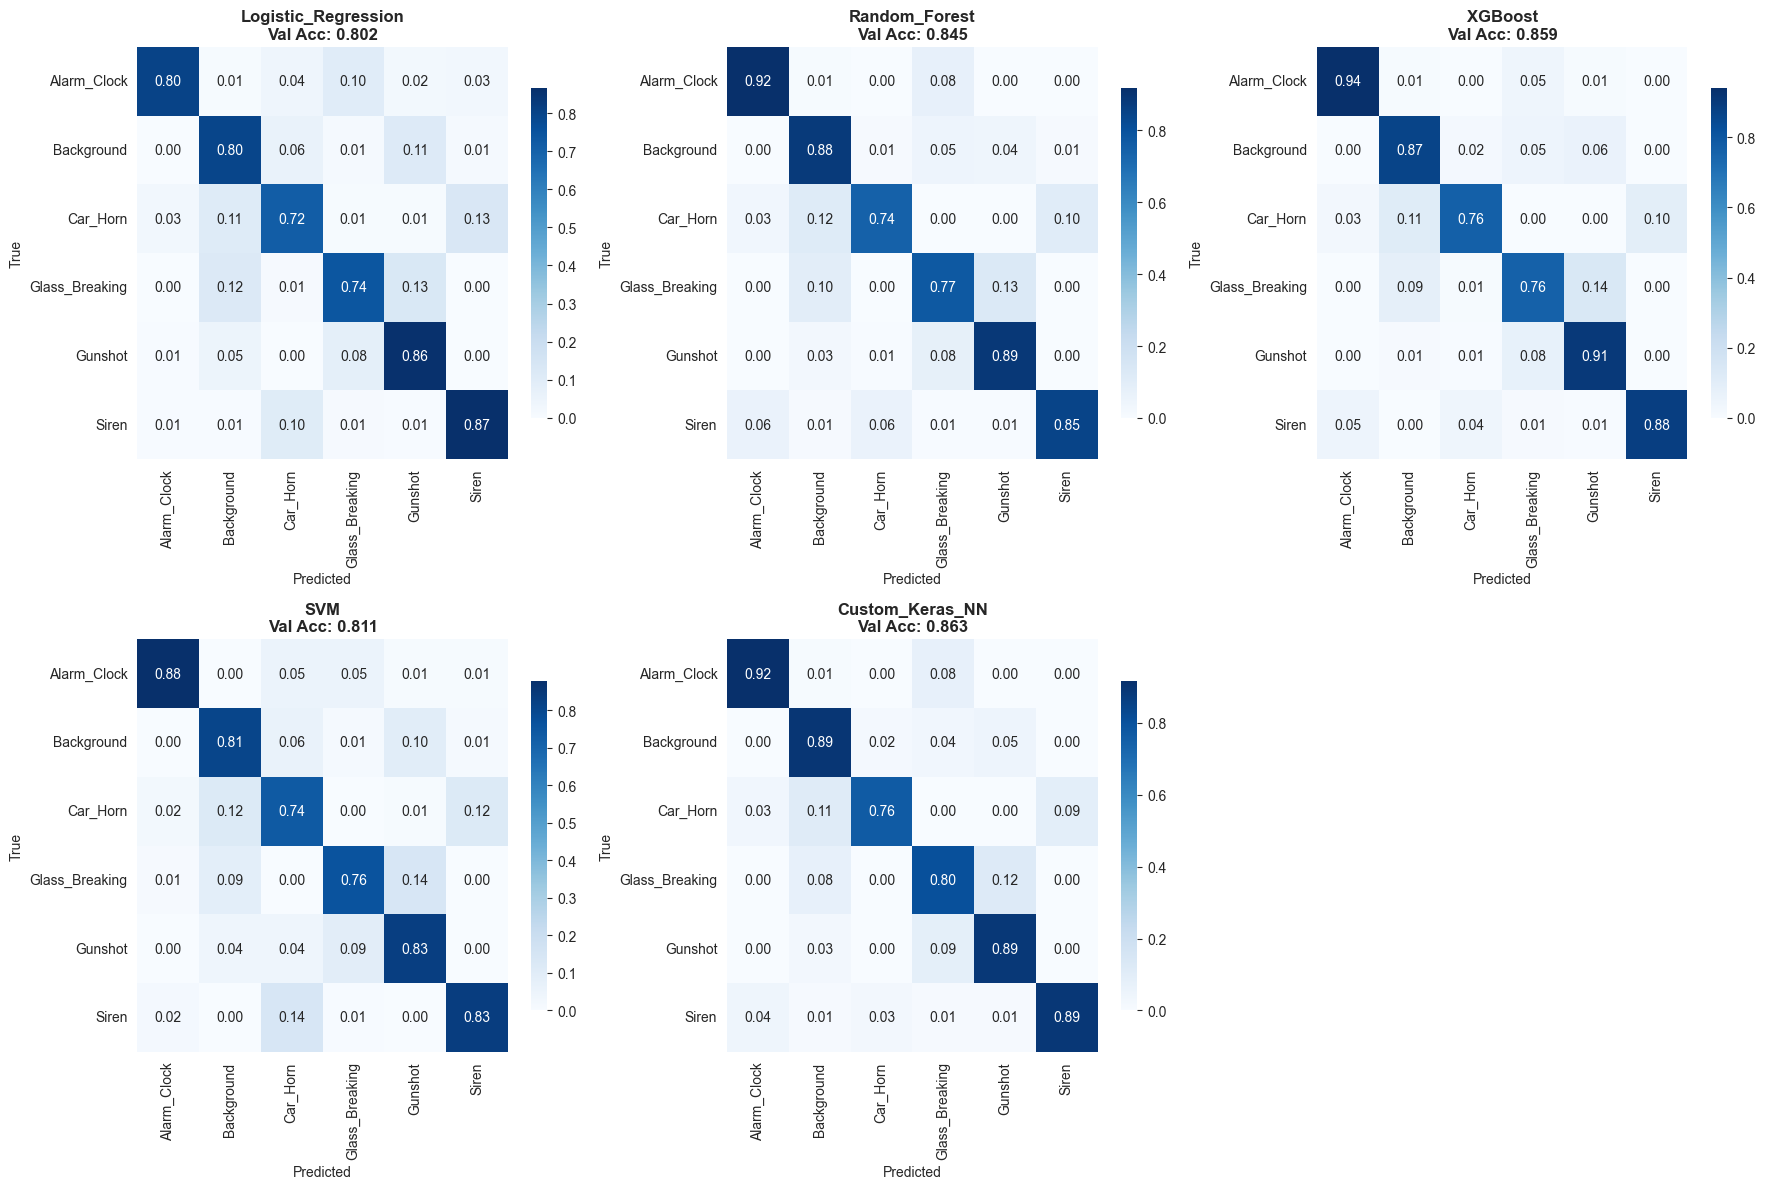

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# --- 1. Fix Imports & Settings ---
# Ensure plt is Matplotlib and sns is Seaborn
sns.set_style("whitegrid") 

# --- 2. Generate Comparison Table ---
print("\nMODEL COMPARISON (Validation F1)\n")

comparison = []
for name, r in results.items():
    # Handle cases where 'val_metrics' might be missing precision/recall (just in case)
    metrics = r['val_metrics']
    comparison.append({
        'Model': name,
        'CV F1': round(r['cv_f1'], 4),
        'Val Acc': round(metrics['accuracy'], 4),
        'Val F1': round(metrics['f1_macro'], 4),
        'Val Precision': round(metrics.get('precision', 0), 4),
        'Val Recall': round(metrics.get('recall', 0), 4)
    })

comp_df = pd.DataFrame(comparison).sort_values('Val F1', ascending=False)
print(comp_df.to_string(index=False))

# Save
comp_path = os.path.join(RESULTS_DIR, 'model_comparison.csv')
comp_df.to_csv(comp_path, index=False)
print(f"\nSaved comparison: {comp_path}")

# --- 3. Generate Confusion Matrices ---
# Create figure using Matplotlib (plt)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

classes = label_encoder.classes_ # Ensure classes are loaded

for idx, (name, r) in enumerate(results.items()):
    # Calculate confusion matrix
    cm = confusion_matrix(y_val_encoded, r['val_pred'])
    
    # Normalize
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot using Seaborn (sns) on the specific axis
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=axes[idx],
                cbar_kws={'shrink': 0.8})
    
    acc = r['val_metrics']['accuracy']
    axes[idx].set_title(f'{name}\nVal Acc: {acc:.3f}', fontweight='bold')
    axes[idx].set_ylabel('True')
    axes[idx].set_xlabel('Predicted')

# Hide unused subplots if fewer than 6 models
if len(results) < 6:
    for j in range(len(results), 6):
        axes[j].axis('off')

plt.tight_layout()
cm_path = os.path.join(RESULTS_DIR, 'val_confusion_matrices.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"Saved validation confusion matrices: {cm_path}")
plt.show()

In [37]:
# FINAL SUMMARY
print("\nTRAINING COMPLETE (Test Set Untouched)")

best = comp_df.iloc[0]
print(f"  Best Model: {best['Model']}")
print(f"  Validation F1: {best['Val F1']}")
print(f"  All models saved: {MODELS_DIR}")
print(f"  Test set preserved for final comparison")


TRAINING COMPLETE (Test Set Untouched)
  Best Model: Custom_Keras_NN
  Validation F1: 0.8567
  All models saved: ../models/models_approach1
  Test set preserved for final comparison
